In [1]:
from nilearn import datasets
from nilearn import datasets
import matplotlib.cm as cm
import matplotlib as plt
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from nilearn import plotting
from nilearn import input_data

/Users/anischihoub/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Dataset Preprocessing #

In [2]:
#This loads in the labels for the dataset, namely the regions of the brain
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
labels = msdl_data["labels"]
masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1).fit()

#load in the dataset with 30 individuals data
data = datasets.fetch_development_fmri(n_subjects=155)

#iterate over the dataset and extract the timeseries data for each individual. we expect a (168,39) matrix per inividual
#pooled subjects will hold the time series matrix per individual
pooled_subjects = []
development_dataset = datasets.fetch_development_fmri(n_subjects=30)
for func_file, confound_file, phenotypic in zip(
        development_dataset.func,
        development_dataset.confounds,
        development_dataset.phenotypic):
    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)


/Users/anischihoub/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/Users/anischihoub/.local/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


# Correlation Computation and Non-private Heatmap #

In [3]:
#compute the correlations per individual
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(pooled_subjects)


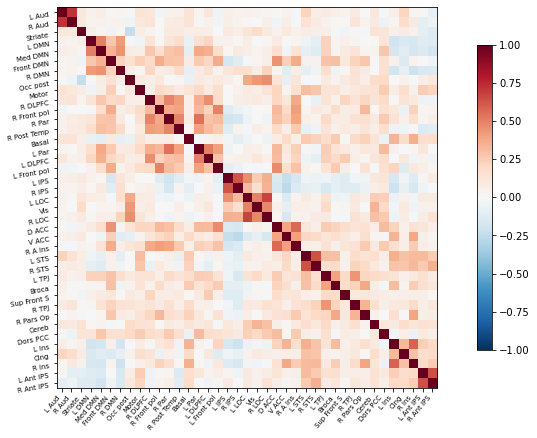

In [4]:
mean_correlation_matrix = correlation_measure.mean_
plotting.plot_matrix(mean_correlation_matrix, 
                     figure=(9, 7), vmax=1, vmin=-1,
                     labels = labels)

# Colormap Manipulations #

Change quantization Levels

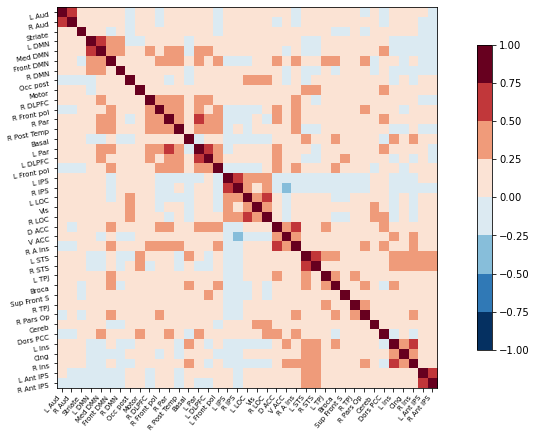

In [5]:
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#use the same cmap, but with 8 evenly space quantization levels
viridis = cm.get_cmap('RdBu_r', 8)
newcolors = viridis(np.linspace(0, 1, 8))
newcmp = ListedColormap(newcolors)
plotting.plot_matrix(mean_correlation_matrix, 
                     figure=(9, 7), vmax=1, vmin=-1,
                     labels = labels,cmap = newcmp)

Linearly Segmented Colormap

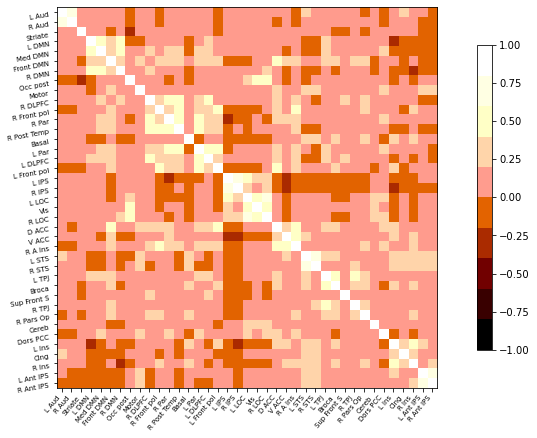

In [6]:
#This dictionary defines the anchor points, with x being a correlation, y1 and y2 represent limits from the left and right respectively
cdict = {'red':   [[0.0,  0.0, 0.0],
                   [0.5,  1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [0.25, 0.0, 0.0],
                   [0.75, 1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'blue':  [[0.0,  0.0, 0.0],
                   [0.5,  0.0, 0.5],
                   [1.0,  1.0, 1.0]]}
newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=10)
plotting.plot_matrix(mean_correlation_matrix, 
                     figure=(9, 7), vmax=1, vmin=-1,
                     labels = labels,cmap = newcmp)

# Sensitivity Experiment #

In [7]:
combined_sets = []
for i in range(len(pooled_subjects)):
    temp = pooled_subjects.copy()
    temp.pop(i)
    combined_sets.append(temp)

/Users/anischihoub/.local/lib/python3.9/site-packages/nilearn/plotting/matrix_plotting.py:151: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figure)


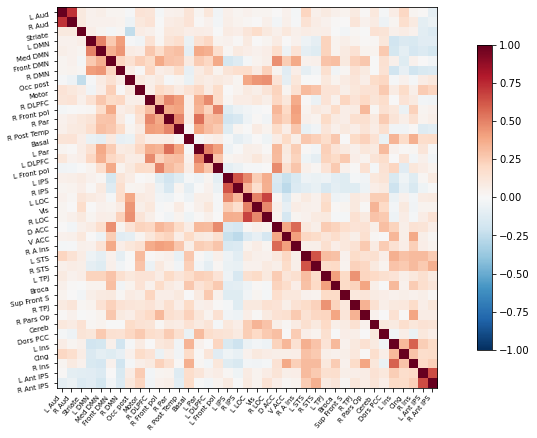

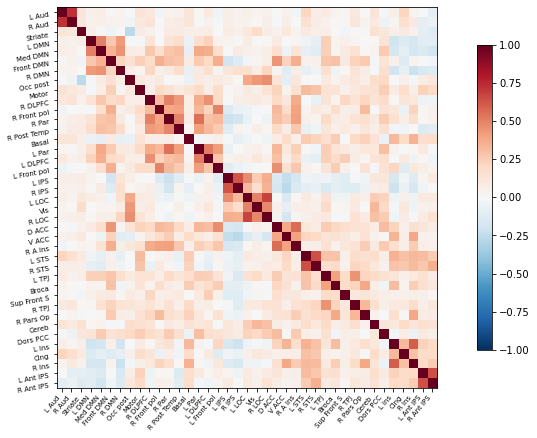

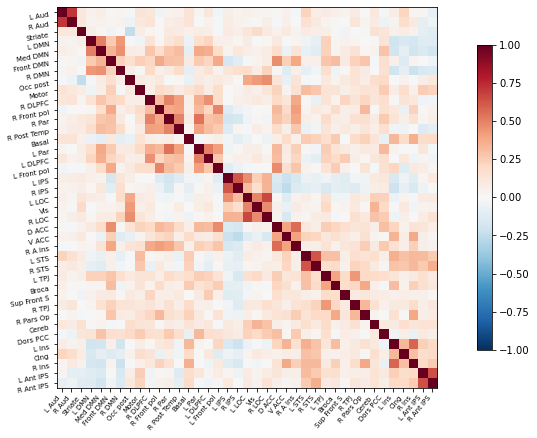

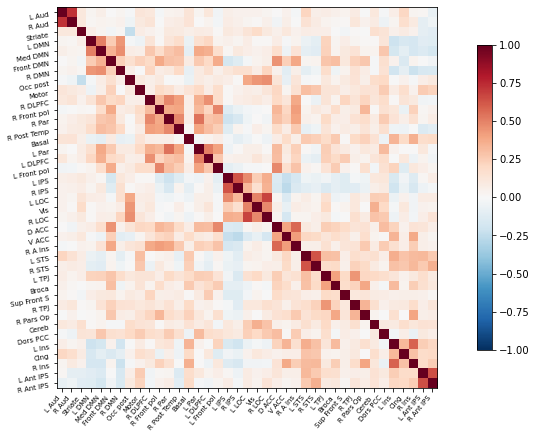

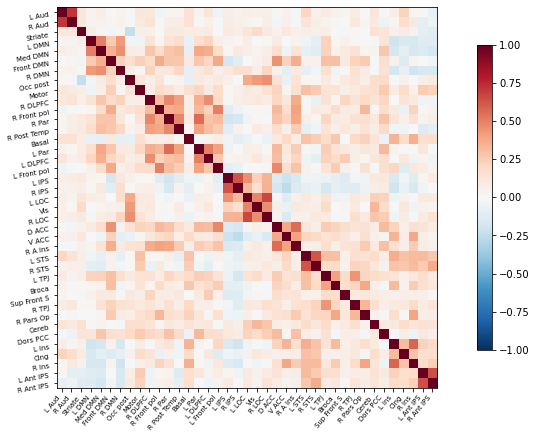

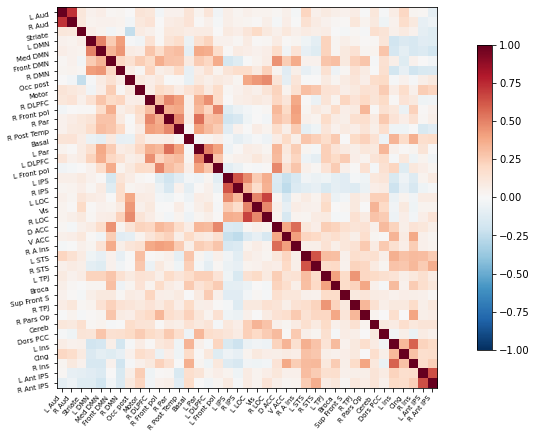

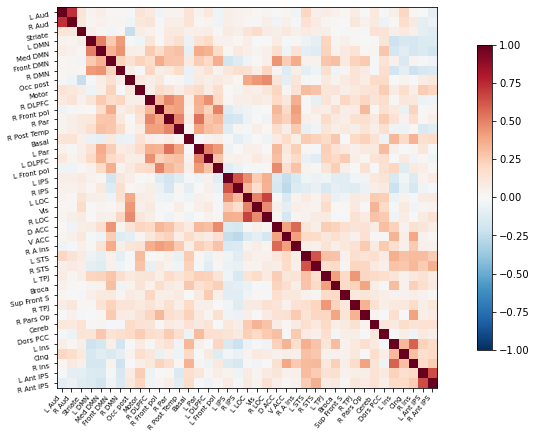

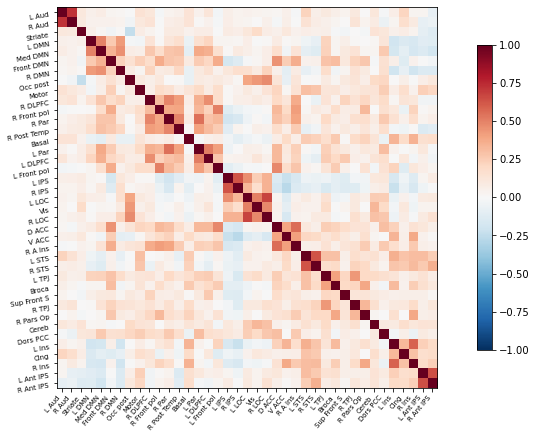

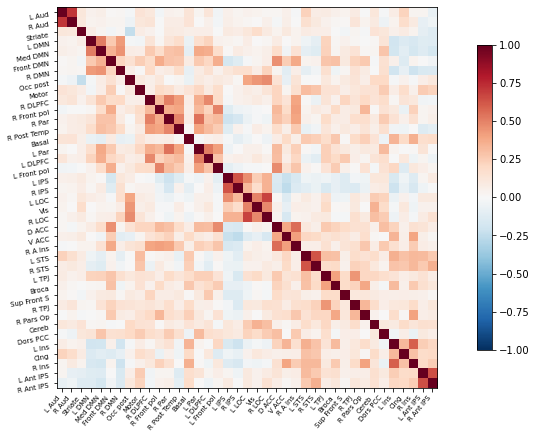

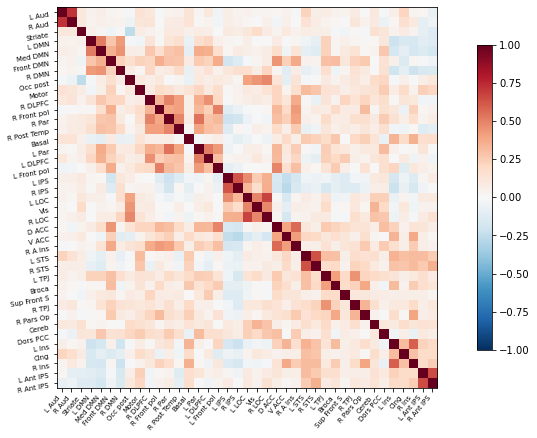

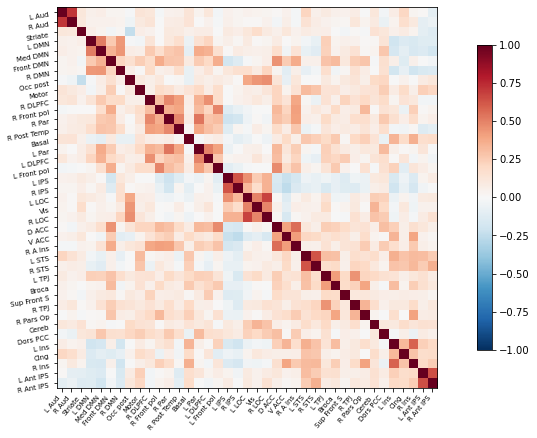

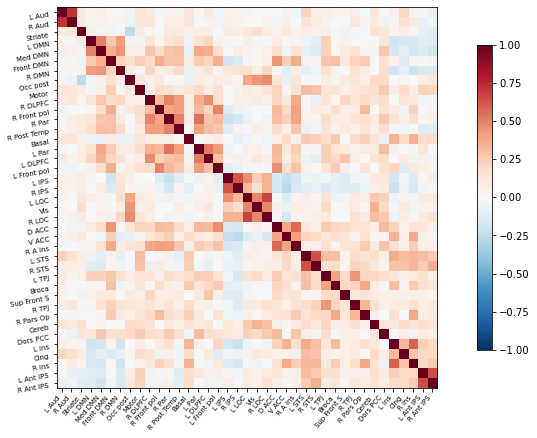

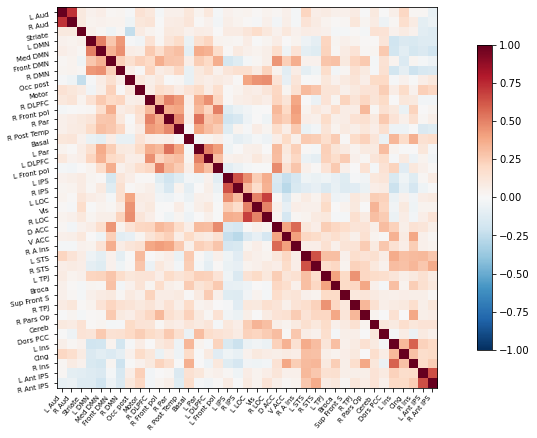

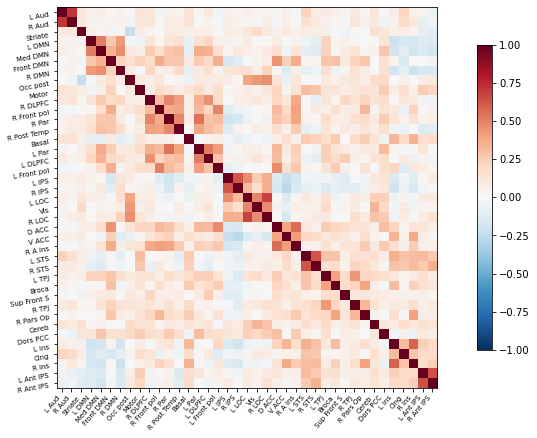

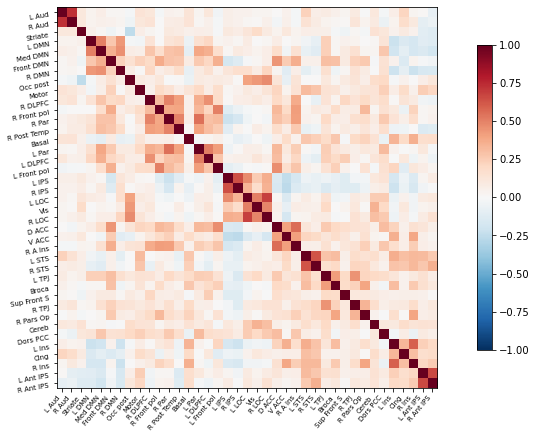

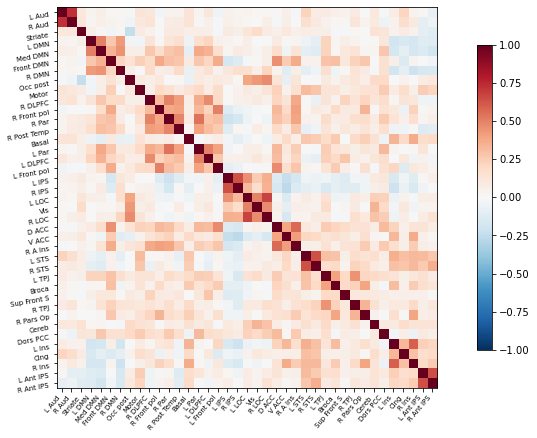

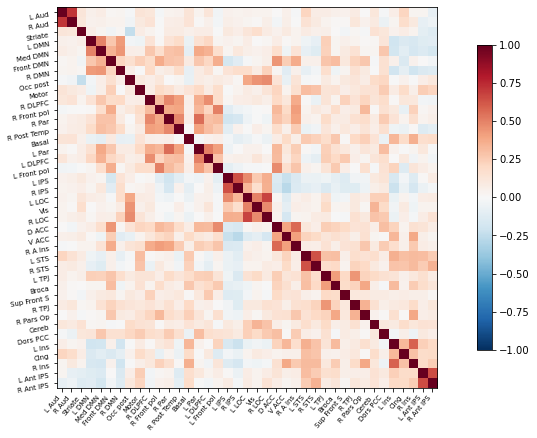

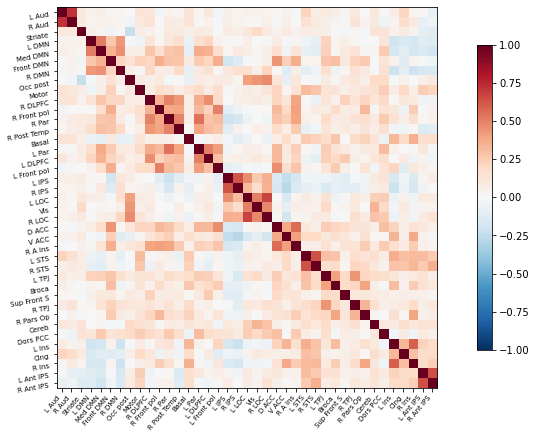

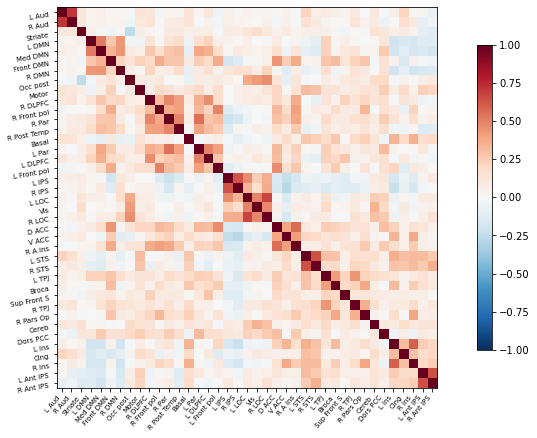

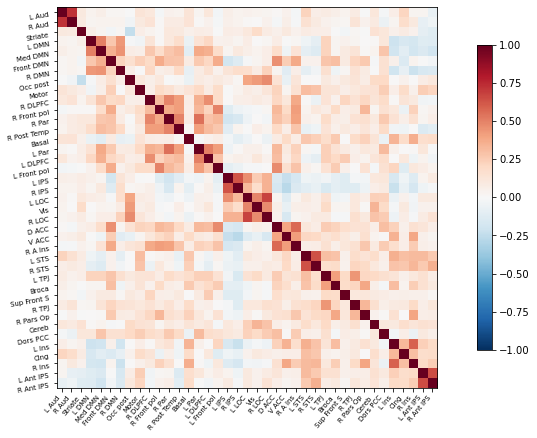

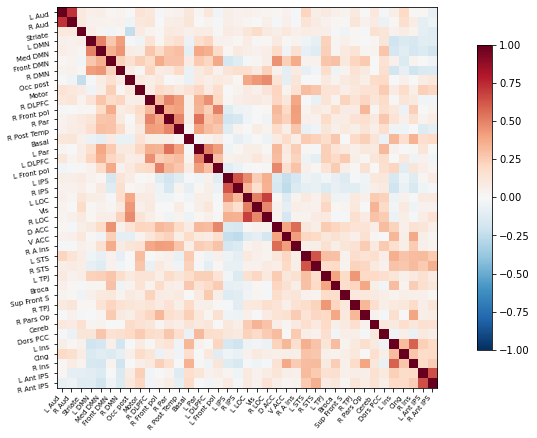

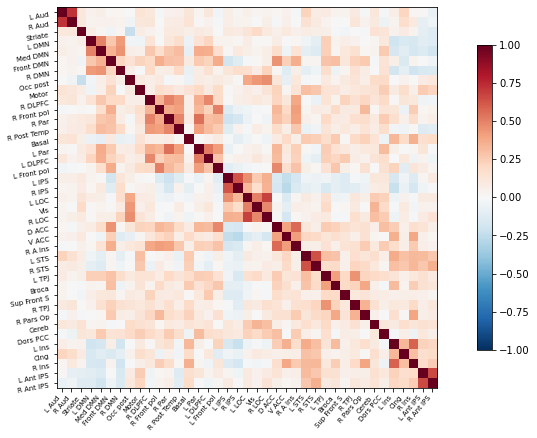

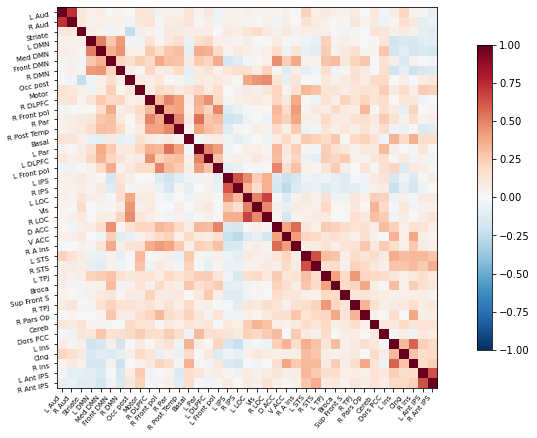

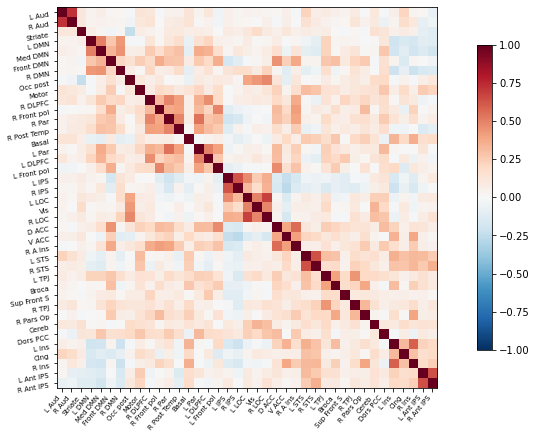

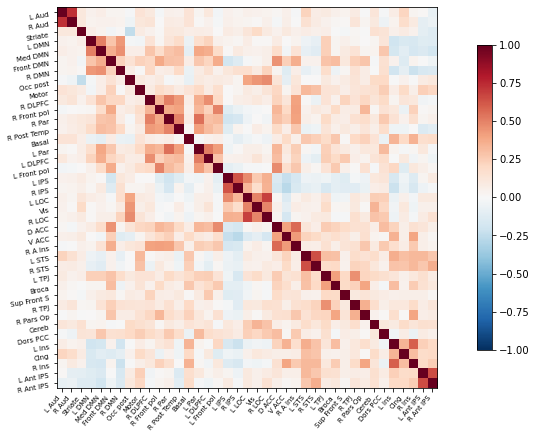

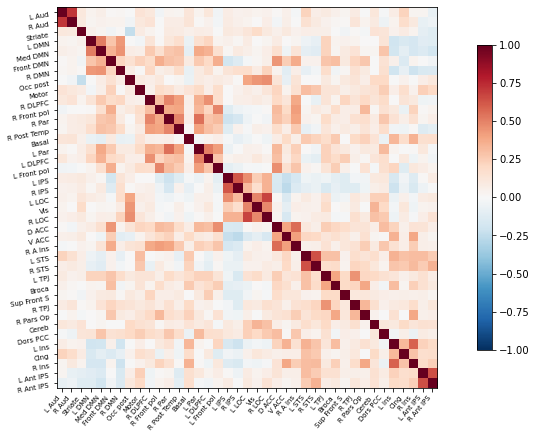

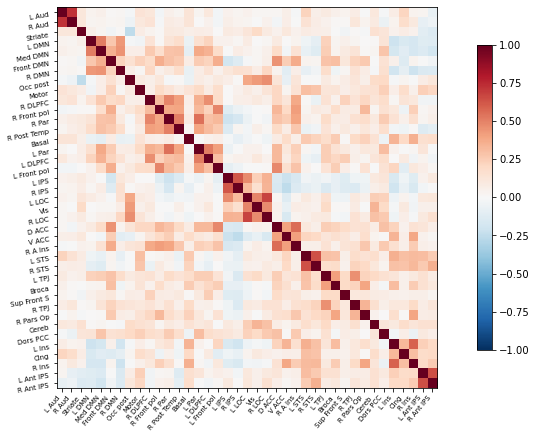

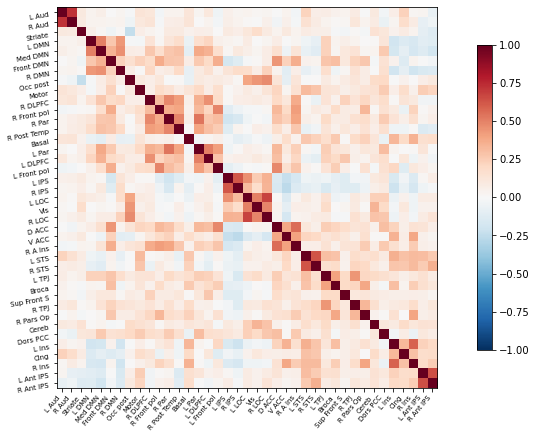

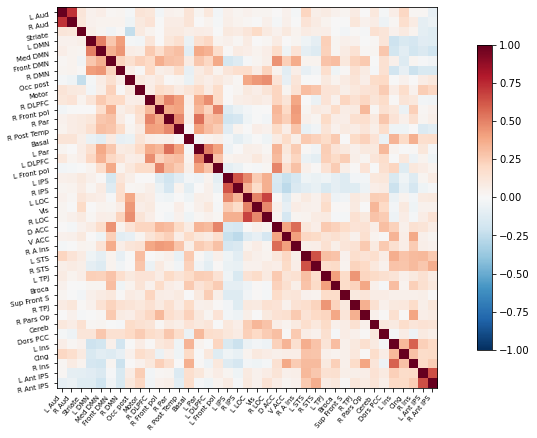

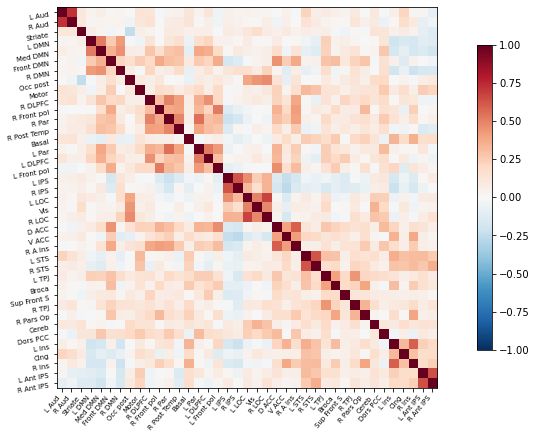

In [8]:
for i in range(len(combined_sets)):
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrices = correlation_measure.fit_transform(combined_sets[i])
    mean_correlation_matrix = correlation_measure.mean_
    plotting.plot_matrix(mean_correlation_matrix, 
                     figure=(9, 7), vmax=1, vmin=-1,
                     labels = labels)

In [9]:
temp = pooled_subjects.copy()
temp.pop(0)
temp.pop(2)
temp.pop(3)

array([[ 1.04415489,  1.1460859 ,  2.04025806, ...,  0.86910443,
         0.36674829, -0.31687283],
       [-0.26578364, -1.84313699, -2.57481243, ...,  2.29813099,
        -0.09487723, -0.31514937],
       [-0.82141349, -3.03155019, -3.3294388 , ...,  2.12511965,
         0.17389445, -0.80492193],
       ...,
       [ 2.920099  ,  3.42412885,  1.26659706, ..., -3.47286309,
        -2.20839649, -1.94742245],
       [-0.27652702,  0.05805802, -1.26621438, ..., -2.43807392,
        -1.0046505 , -0.58377663],
       [-0.15392426, -0.30041773,  1.95685609, ..., -0.35424722,
        -0.5728761 , -0.74620865]])

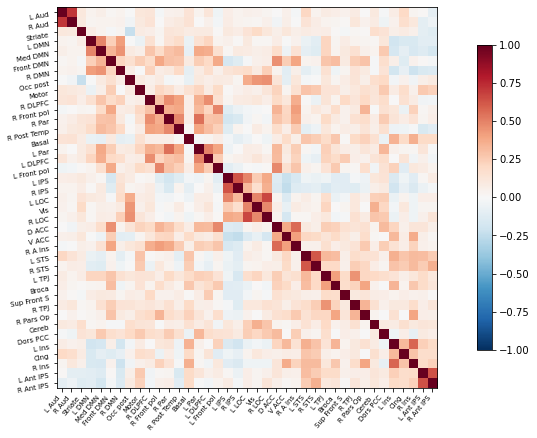

In [10]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(temp)
mean_correlation_matrix = correlation_measure.mean_
plotting.plot_matrix(mean_correlation_matrix, 
                     figure=(9, 7), vmax=1, vmin=-1,
                     labels = labels)

In [11]:
len(temp)

27

Privacy ideas:
- Can we noise up each pixel based on the correlation value?  
    - Sensitivity notion makes this hard, we are also averaging the correlations
- Do something with the 30 datasets, make a heatmap with some aggregation of individuals. 
- Color map randomization?
    - the non-linear mapping example from matplotlib 
    - what numbers map to what colors
    - Change where color points are. 
    - value -> then randomly choose color, and then round
    - noise and then round


Meeting Notes

- change the rows and columns 
- regime (big sample)(noise) vs (small sample)
- Get Ye's dataset 
- Typical sample sizes and useful visualizations in papers (get published papers)
- plot of privacy parameters with the connectivity 

Matrix

In [3]:
from mat4py import loadmat
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt

In [8]:
FC_all = loadmat('FC.mat')
num_SZ = len(FC_all['SZMatrix'])
num_TC = len(FC_all['TCMatrix'])
num_nodes = 53

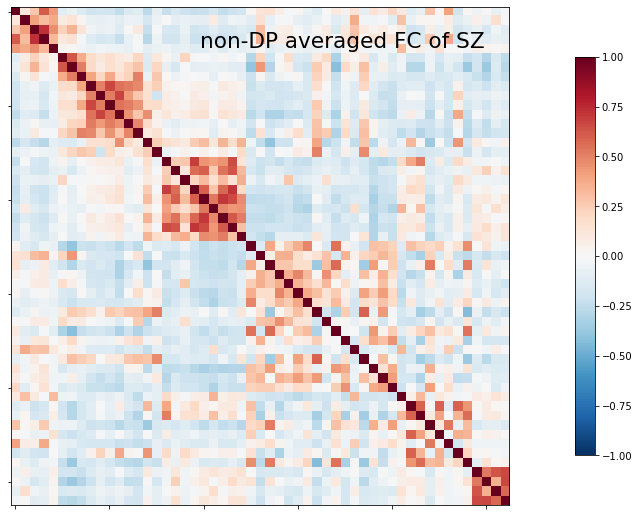

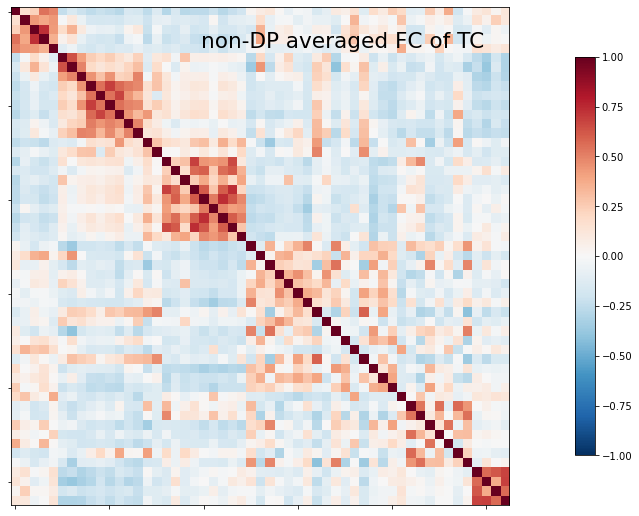

In [9]:
# Reformat data
ind = np.triu_indices(num_nodes, 1)
# 1. FC for SZ group without regress out the site effects
SZMatrix = FC_all['SZMatrix']
SZ_Noregress = np.zeros((num_SZ, num_nodes, num_nodes))
for i in range(num_SZ):
    SZ_Noregress[i][ind] = SZMatrix[i]
    SZ_Noregress[i] = SZ_Noregress[i] + SZ_Noregress[i].T + np.diag([1]*num_nodes)
# 2. FC for TC group without regress out the site effects
TCMatrix = FC_all['TCMatrix']
TC_Noregress = np.zeros((num_TC, num_nodes, num_nodes))
for i in range(num_TC):
    TC_Noregress[i][ind] = TCMatrix[i]
    TC_Noregress[i] = TC_Noregress[i] + TC_Noregress[i].T + np.diag([1]*num_nodes)
# Compute and plot the average FC
# 1. SZ_Noregress
SZ_Noregress_ave = np.mean(SZ_Noregress, axis=0)
fig = plt.figure(figsize=(9,7))
plotting.plot_matrix(SZ_Noregress_ave, figure=fig, vmax=1, vmin=-1, title='non-DP averaged FC of SZ')
fig.savefig('SZ_Noregress_ave', dpi=300)
# 2. TC_Noregress
TC_Noregress_ave = np.mean(TC_Noregress, axis=0)
fig = plt.figure(figsize=(9,7))
plotting.plot_matrix(TC_Noregress_ave, figure=fig, vmax=1, vmin=-1, title='non-DP averaged FC of TC')
fig.savefig('TC_Noregress_ave', dpi=300)

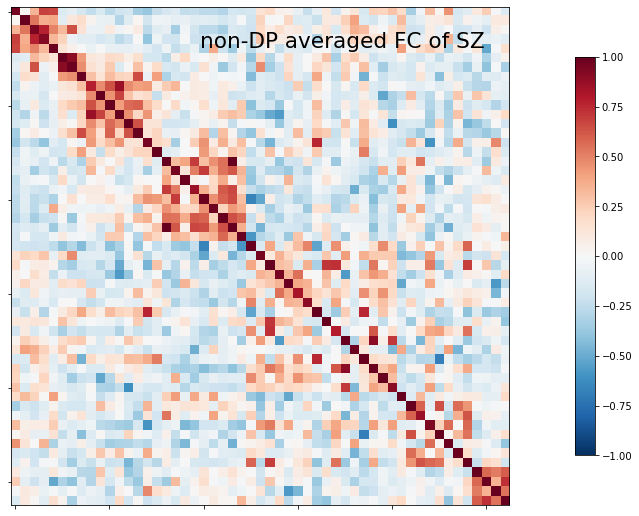

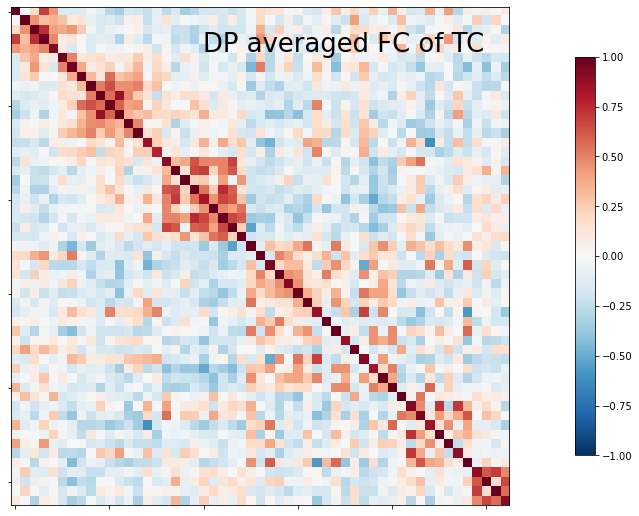

In [10]:
epsilon = 1e-2
#double check if we need 2 or 1 here
weights_sens = 2./num_SZ
nse_mat = np.random.laplace(0,scale=weights_sens/epsilon,size = SZ_Noregress_ave.shape)
#keep the matrix positve semidefinite
upper_nse_mat = np.triu(nse_mat, 0)
lower_triangle = np.triu(nse_mat,1)
upper_nse_mat = upper_nse_mat + lower_triangle.transpose()
SZ_Noregress_dp_laplace =  SZ_Noregress_ave+upper_nse_mat 
fig = plt.figure(figsize=(9,7))
plotting.plot_matrix(SZ_Noregress_dp_laplace, figure=fig, vmax=1, vmin=-1, title='non-DP averaged FC of SZ')
epsilon = 2
delta = 1e-4
c2 = 2*np.log(1.25/delta)
weights_sens = 2./num_SZ
nsv = np.sqrt(c2*weights_sens/epsilon**2)
nse_mat = np.random.normal(0,scale=nsv,size = SZ_Noregress_ave.shape)
#keep the matrix positve semidefinite
upper_nse_mat = np.triu(nse_mat, 0)
lower_triangle = np.triu(nse_mat,1)
upper_nse_mat = upper_nse_mat + lower_triangle.transpose()
SZ_Noregress_dp_laplace =  SZ_Noregress_ave+upper_nse_mat 
fig = plt.figure(figsize=(9,7))
plotting.plot_matrix(SZ_Noregress_dp_laplace, figure=fig, vmax=1, vmin=-1, title='DP averaged FC of TC')

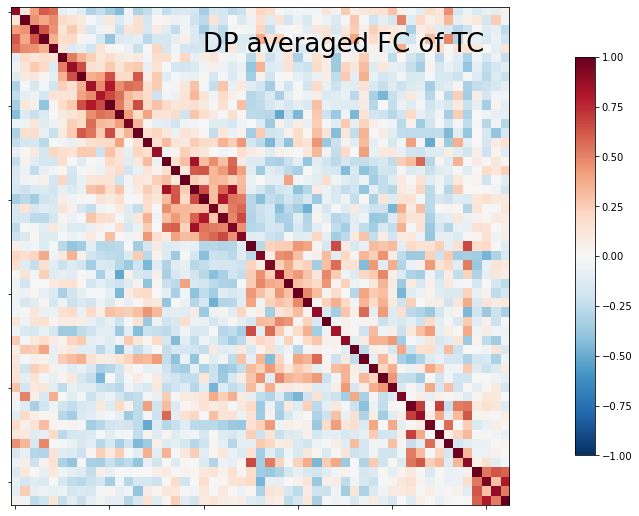

In [12]:
epsilon = 2
delta = 1e-4
c2 = 2*np.log(1.25/delta)
weights_sens = 2./num_SZ
nsv = np.sqrt(c2*weights_sens/epsilon**2)
nse_mat = np.random.normal(0,scale=nsv,size = SZ_Noregress_ave.shape)
#keep the matrix positve semidefinite
upper_nse_mat = np.triu(nse_mat, 0)
lower_triangle = np.triu(nse_mat,1)
upper_nse_mat = upper_nse_mat + lower_triangle.transpose()
SZ_Noregress_dp_laplace =  SZ_Noregress_ave+upper_nse_mat 
fig = plt.figure(figsize=(9,7))
plotting.plot_matrix(SZ_Noregress_dp_laplace, figure=fig, vmax=1, vmin=-1, title='DP averaged FC of TC')

Plotting the Matrices with Laplacian Noise (Need to merge, matplotlib does not like the axes and the color bar)

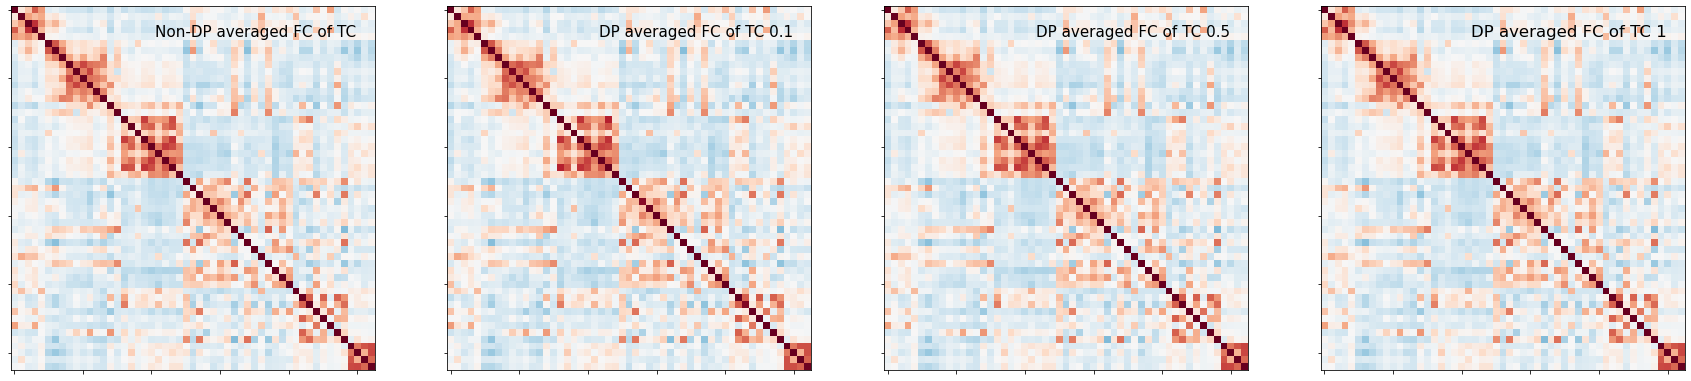

In [44]:
f, axs = plt.subplots(1,4,figsize=(30,30))
epsilon = [0,0.1,0.5,1]
for i,(eps,ax) in enumerate(zip(epsilon, axs)):
    if eps == 0:
        plotting.plot_matrix(SZ_Noregress_ave,vmax=1, colorbar=False, vmin=-1, title='Non-DP averaged FC of TC',axes = ax)    
    else:
        #double check if we need 2 or 1 here
        weights_sens = 2./num_SZ
        nse_mat = np.random.laplace(0,scale=weights_sens/eps,size = SZ_Noregress_ave.shape)
        #keep the matrix positve semidefinite
        upper_nse_mat = np.triu(nse_mat, 0)
        lower_triangle = np.triu(nse_mat,1)
        upper_nse_mat = upper_nse_mat + lower_triangle.transpose()
        mat =  SZ_Noregress_ave+upper_nse_mat 
        plotting.plot_matrix(mat,vmax=1, vmin=-1, title='DP averaged FC of SZ {}'.format(eps),axes = ax,colorbar=False)    

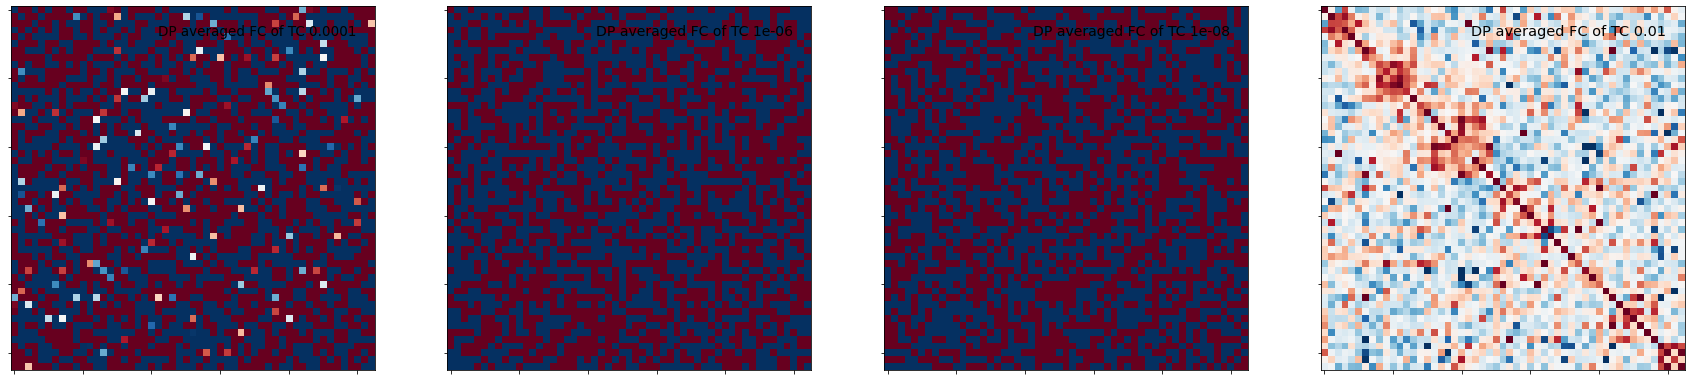

In [45]:
f, axs = plt.subplots(1,4,figsize=(30,30))
epsilon = [1e-4,1e-6,1e-8,1e-2]
for i,(eps,ax) in enumerate(zip(epsilon, axs)):
    if eps == 0:
        plotting.plot_matrix(SZ_Noregress_ave,vmax=1, colorbar=False, vmin=-1, title='Non-DP averaged FC of TC',axes = ax)    
    else:
        #double check if we need 2 or 1 here
        weights_sens = 2./num_SZ
        nse_mat = np.random.laplace(0,scale=weights_sens/eps,size = SZ_Noregress_ave.shape)
        #keep the matrix positve semidefinite
        upper_nse_mat = np.triu(nse_mat, 0)
        lower_triangle = np.triu(nse_mat,1)
        upper_nse_mat = upper_nse_mat + lower_triangle.transpose()
        mat =  SZ_Noregress_ave+upper_nse_mat 
        plotting.plot_matrix(mat,vmax=1, vmin=-1, title='DP averaged FC of SZ {}'.format(eps),axes = ax,colorbar=False)    

Plotting the Matrices with Gaussian Noise (Need to merge, matplotlib does not like the axes and the color bar)

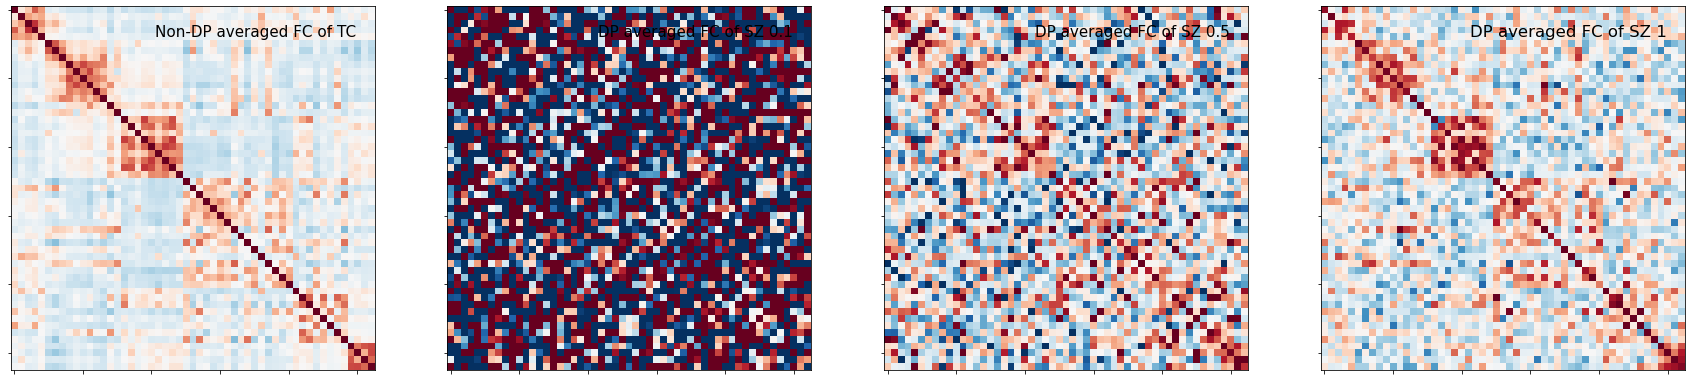

In [49]:
f, axs = plt.subplots(1,4,figsize=(30,30))
epsilon = [0,0.1,0.5,1]
for i,(eps,ax) in enumerate(zip(epsilon, axs)):
    if eps == 0:
        plotting.plot_matrix(SZ_Noregress_ave,vmax=1, colorbar=False, vmin=-1, title='Non-DP averaged FC of TC',axes = ax)    
    else:
        delta = 1e-6
        c2 = 2*np.log(1.25/delta)
        weights_sens = 2./num_SZ
        nsv = np.sqrt(c2*weights_sens/eps**2)
        nse_mat = np.random.normal(0,scale=nsv,size = SZ_Noregress_ave.shape)
        #keep the matrix positve semidefinite
        upper_nse_mat = np.triu(nse_mat, 0)
        lower_triangle = np.triu(nse_mat,1)
        upper_nse_mat = upper_nse_mat + lower_triangle.transpose()
        mat =  SZ_Noregress_ave+upper_nse_mat 
        plotting.plot_matrix(mat,vmax=1, vmin=-1, title='DP averaged FC of SZ {}'.format(eps),axes = ax,colorbar=False)    

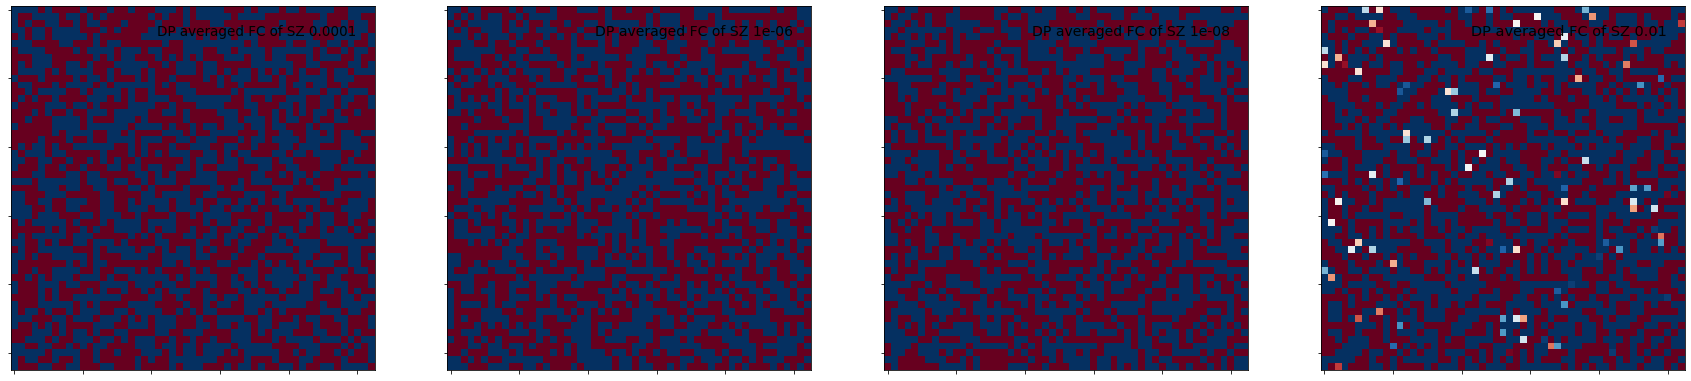

In [50]:
f, axs = plt.subplots(1,4,figsize=(30,30))
epsilon = [1e-4,1e-6,1e-8,1e-2]
for i,(eps,ax) in enumerate(zip(epsilon, axs)):
    if eps == 0:
        plotting.plot_matrix(SZ_Noregress_ave,vmax=1, colorbar=False, vmin=-1, title='Non-DP averaged FC of TC',axes = ax)    
    else:
        delta = 1e-6
        c2 = 2*np.log(1.25/delta)
        weights_sens = 2./num_SZ
        nsv = np.sqrt(c2*weights_sens/eps**2)
        nse_mat = np.random.normal(0,scale=nsv,size = SZ_Noregress_ave.shape)
        #keep the matrix positve semidefinite
        upper_nse_mat = np.triu(nse_mat, 0)
        lower_triangle = np.triu(nse_mat,1)
        upper_nse_mat = upper_nse_mat + lower_triangle.transpose()
        mat =  SZ_Noregress_ave+upper_nse_mat 
        plotting.plot_matrix(mat,vmax=1, vmin=-1, title='DP averaged FC of SZ {}'.format(eps),axes = ax,colorbar=False)    

Connectome Plots (we need to msdl coordinates, get those later)

Exponential Method Colormap